In [1]:
# Imports
import gymnasium as gym
import numpy as np
import random
from environments.grid_world import GridWorldEnv
import matplotlib.pyplot as plt

In [2]:
### Deterministic GridWorld
gym.register(
    id="gymnasium_env/GridWorld-v2",
    entry_point=GridWorldEnv,
    max_episode_steps=300,  # Prevent infinite episodes
)

In [49]:
# Environment
env = gym.make("gymnasium_env/GridWorld-v2", render_mode='rgb_array')
env.reset()
num_states = env.observation_space.n
num_actions = env.action_space.n

In [50]:
# SARSA Class
class SARSA:
    def __init__(self, env, num_states, num_actions):
        self.env = env
        self.num_states = num_states
        self.num_actions = num_actions
        self.Q = np.zeros((self.num_states, self.num_actions))
        self.policy = {state: 0 for state in range(self.num_states)}

    def select_action(self, state, epsilon=.2):
        if np.random.rand() < epsilon:
            return np.random.choice(self.num_actions)
        return np.argmax(self.Q[state])

    def update_q_table(self, state, action, reward, next_state, next_action, alpha=.1, gamma=.8):
        old_q_value = self.Q[state, action]
        new_q_value = self.Q[next_state, next_action]
        self.Q[state, action] = old_q_value + alpha * (reward + gamma * new_q_value - old_q_value)

    def get_policy(self):
        for state in range(self.num_states):
            self.policy[state] = np.argmax(self.Q[state]) # Action with the highest Q-value

    def train(self, num_episodes=1000):
        for _ in range(num_episodes):
            state, _ = env.reset()
            action = self.select_action(state)
            terminated = False
            while not terminated:
                next_state, reward, terminated, _, _ = env.step(action)
                next_action = self.select_action(next_state)
                self.update_q_table(state, action, reward, next_state, next_action)
                state, action = next_state, next_action

    def evaluate(self, num_episodes=1):
        self.get_policy()
        episode_total_reward = 0
        for _ in range(num_episodes):
            state, _ = env.reset()
            terminated = False
            while not terminated:
                action = self.policy[state] # Take best action based on learned policy
                next_state, reward, terminated, _, _ = env.step(action)
                state = next_state
                episode_total_reward += reward
            print(f"Total collected rewards: {episode_total_reward}")

In [51]:
sarsa = SARSA(env, num_states, num_actions)
sarsa.train()

In [56]:
sarsa.evaluate()

Total collected rewards: 7.0


In [57]:
# Actions are represented as: (3 → left, 2 → down, 1 → right, 0 → up).
sarsa.policy

{0: np.int64(2),
 1: np.int64(2),
 2: np.int64(2),
 3: np.int64(1),
 4: np.int64(1),
 5: np.int64(2),
 6: np.int64(1),
 7: np.int64(1),
 8: np.int64(0)}

In [58]:
sarsa.Q

array([[ 0.35805623,  1.44326493,  1.70409473,  0.25060162],
       [ 1.39196683,  2.65040832,  3.66459834, -0.04224766],
       [ 0.65029519,  1.67038132,  6.30079379,  0.57925332],
       [-0.12670294,  3.85945636,  0.53488267,  1.41690836],
       [ 1.21190347,  5.75766106,  5.00731776,  1.6662737 ],
       [ 3.59923627,  6.59691951, 10.        ,  2.93174143],
       [-0.31718902,  5.78651651,  0.28938299,  0.15547447],
       [ 1.65064405,  9.99976095,  1.86605374,  0.55115966],
       [ 0.        ,  0.        ,  0.        ,  0.        ]])

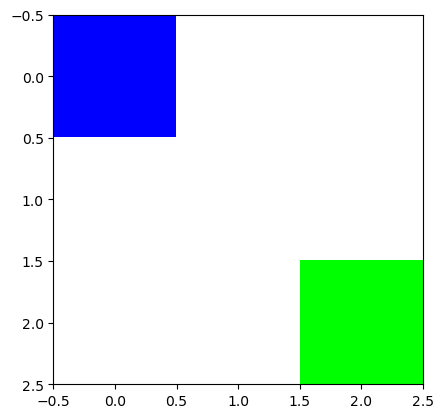

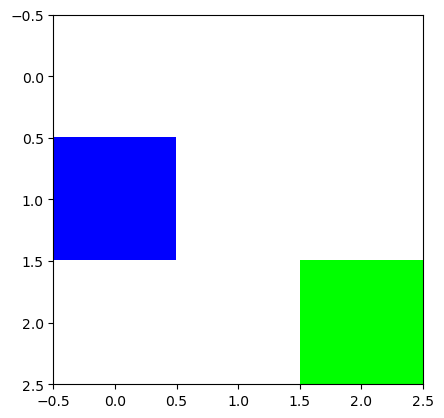

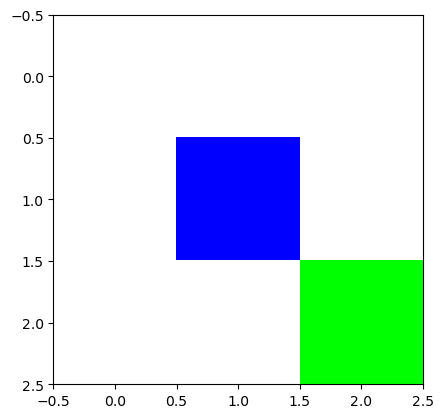

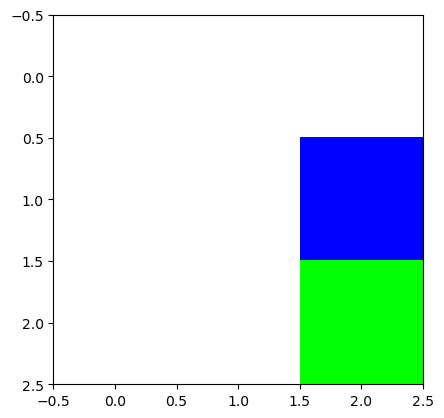

<Figure size 640x480 with 0 Axes>

In [59]:
def simulate_policy(env, policy, pause=0.5):
    state, _ = env.reset()

    done = False
    while not done:
        # Render
        img = env.render()
        if img is not None:
            plt.imshow(img)
            plt.axis('on')
            plt.show(block=False)
            plt.pause(pause)
            plt.clf()

        # Take action from policy
        action = policy[state]
        state, reward, done, _, _ = env.step(action)

simulate_policy(env, sarsa.policy, pause=0.7)